In [1]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset|
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from MountainDataset import MountainDataset
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
DEVICE

False


'cpu'

In [2]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
image_path = "./dataset"
train_data = MountainDataset(image_path, maxlen=100)


In [4]:
print(train_data)

Mountain Data Set
Root directory: {self.rootDir}Length 100


In [5]:
#TODO Data Normalization should be done Previously. Saves Startup time
def create_validation_set(train_data, train_percentage, test_transforms = None):

    
    n_train_examples = int(len(train_data) * train_percentage)
    n_valid_examples = len(train_data) - n_train_examples
    
     # Create 'Subset' objects
    train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

    print(f"Number training examples: {len(train_data)}")
    print(f"Number validation examples: {len(valid_data)}")

    # Apply test transformations to the validation set
    valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
    valid_data.dataset.transform = test_transforms

    return valid_data

In [6]:
valid_data = create_validation_set(train_data, 0.8)

Number training examples: 80
Number validation examples: 20


In [7]:
# Create iterators
#TODO: Maybe change batch Size to 32 if memory runs out
BATCH_SIZE = 16

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size=BATCH_SIZE)

#test_iterator = torch.utils.data.DataLoader(test_data, 
#                                            batch_size=BATCH_SIZE)

In [8]:
from unet_model import UNet
model = UNet(1)#, 1, bilinear=False)

In [9]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 1,861,697 trainable parameters.


In [10]:
#Todo look more into the Criterion for now Softmax + Crossentropy sounds good
# Loss
# Crossentropy works only with multiple classes -> use BCEwith logitsloss instead
#criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
criterion = nn.BCEWithLogitsLoss()
# Put model&criterion on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [11]:
# Optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)#, momentum=0.99)

optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

model = model.to(device)

In [12]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()
    
    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)
    
    
    # Compute accuracy
    acc = calculate_accuracy(y_pred, y, BATCH_SIZE)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  #print(f"epoch_acc:{epoch_acc/len(iterator)} , len: {len(iterator)}")
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [13]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)
      
      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)
      
      for i in range(2):
        plot_img(y_pred[i,0], y[i,0])
      # Compute accuracy
      acc = calculate_accuracy(y_pred, y, BATCH_SIZE)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def plot_img(im1, im2):
  fig = plt.figure(figsize=(20,10))
  gs = fig.add_gridspec(1,2, hspace=0)
  (ax1, ax2) = gs.subplots()
  ax1.imshow(im1)
  ax2.imshow(im2)
  #cbar_ax = fig.add_axes([0,0, im1.size()[0], im1.size()[1]])
  #fig.subplots_adjust(right=0.8)
  #fig.colorbar(im2.detach().numpy(), cax=cbar_ax)
  plt.show()

In [14]:
def acc(pred, mask):
    compare= np.equal(pred.detach().numpy(), mask.detach().numpy())
    accuracy = np.sum(compare)
    return accuracy/len(pred.flatten())



def calculate_accuracy(y_pred, y, batch_size):
    '''
    Compute accuracy from ground-truth and predicted labels.
    
    Input
    ------
    y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
    y: torch.Tensor [BATCH_SIZE]
  
    Output
    ------
    acc: float
      Accuracy
    '''
    batch_size= min(y.shape[0], batch_size)
    total_acc = 0
    for i in range(batch_size):
        total_acc += acc(y_pred[i], y[i])
    
    
    return total_acc/batch_size

In [15]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()
    
    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

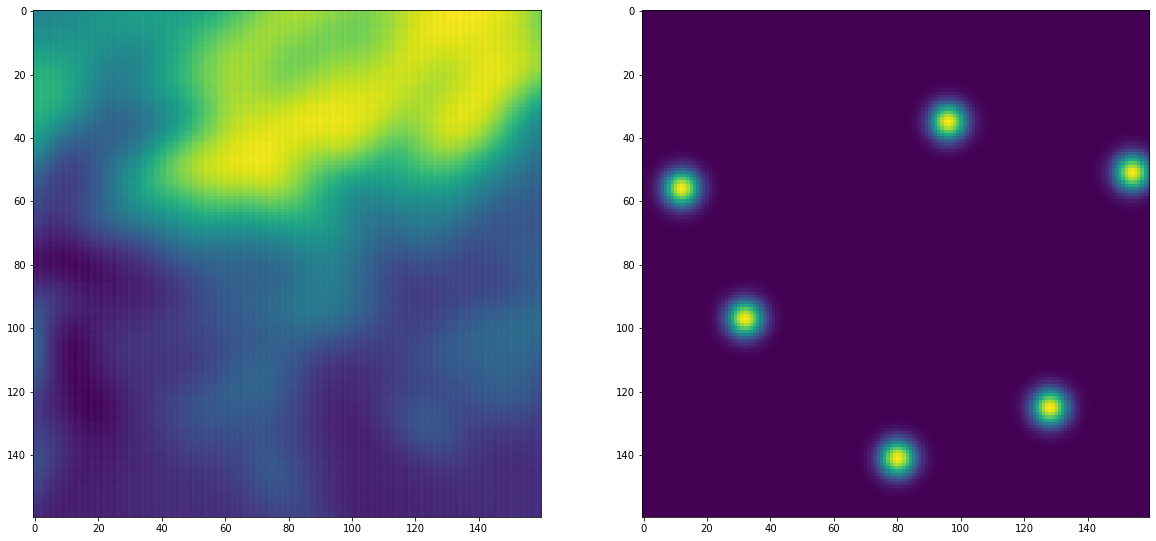

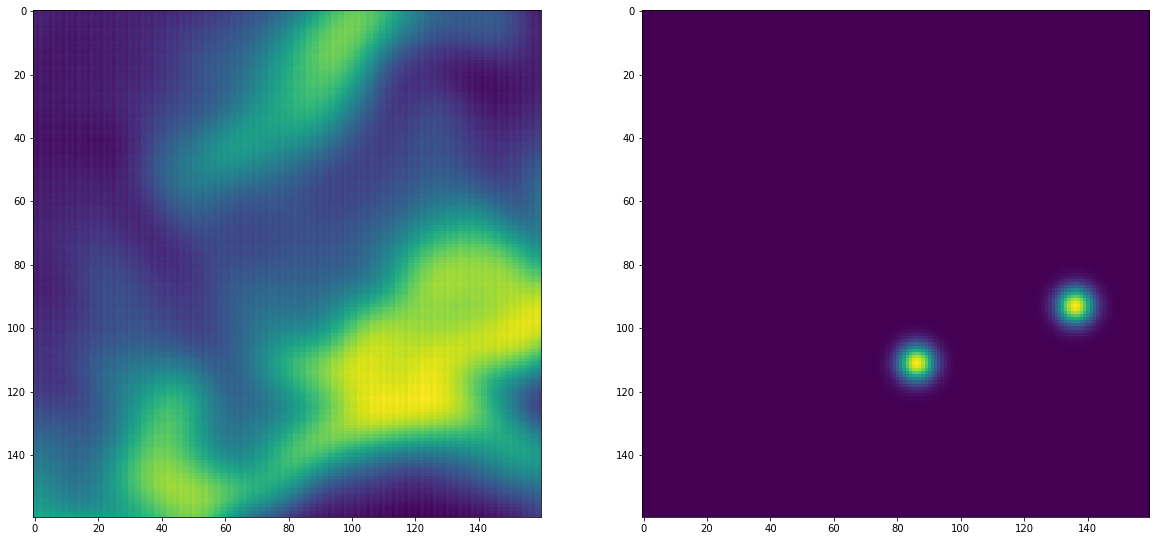

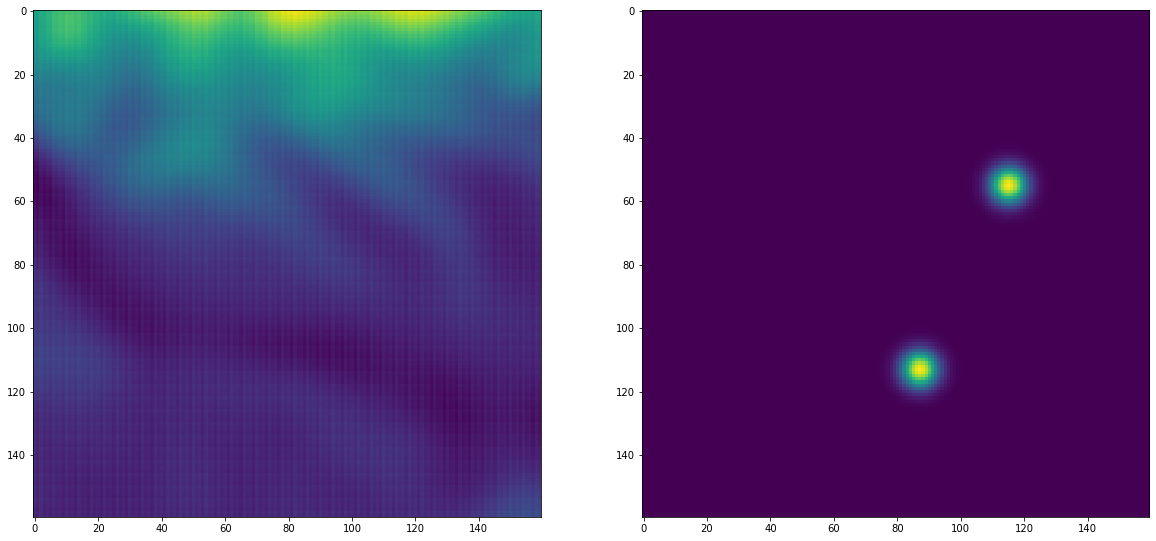

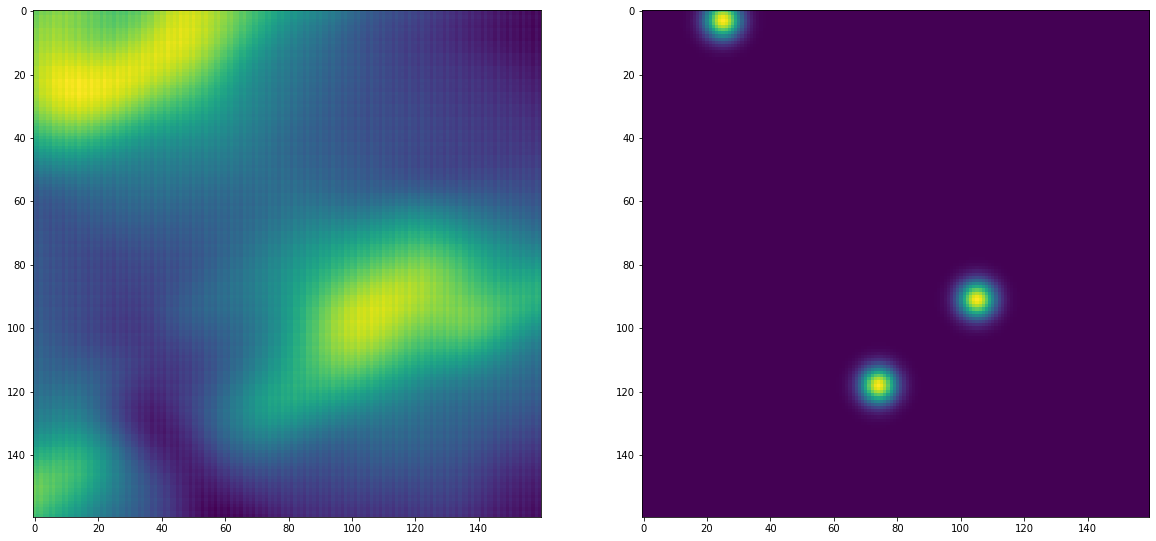


Epoch: 1/60 -- Epoch Time: 175.78 s
---------------------------------
Train -- Loss: 4696.731, Acc: 0.00%
Val -- Loss: 6886.266, Acc: 0.00%


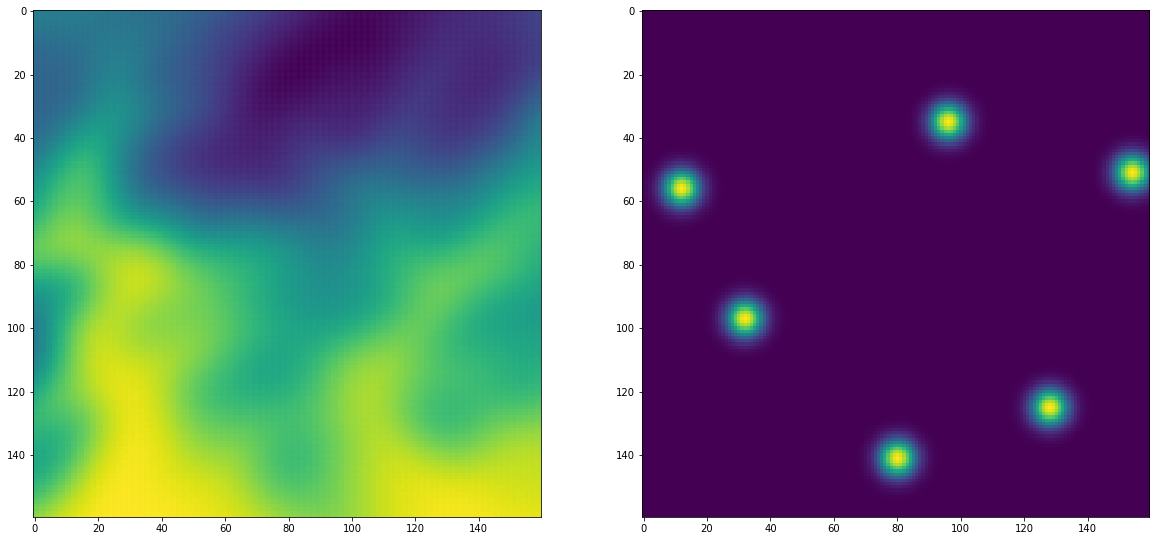

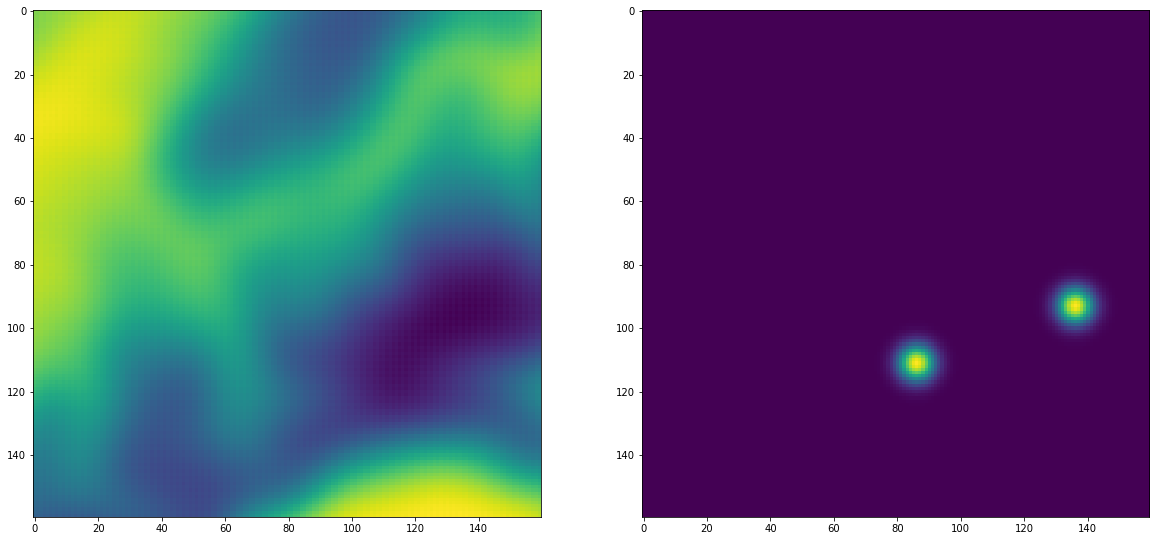

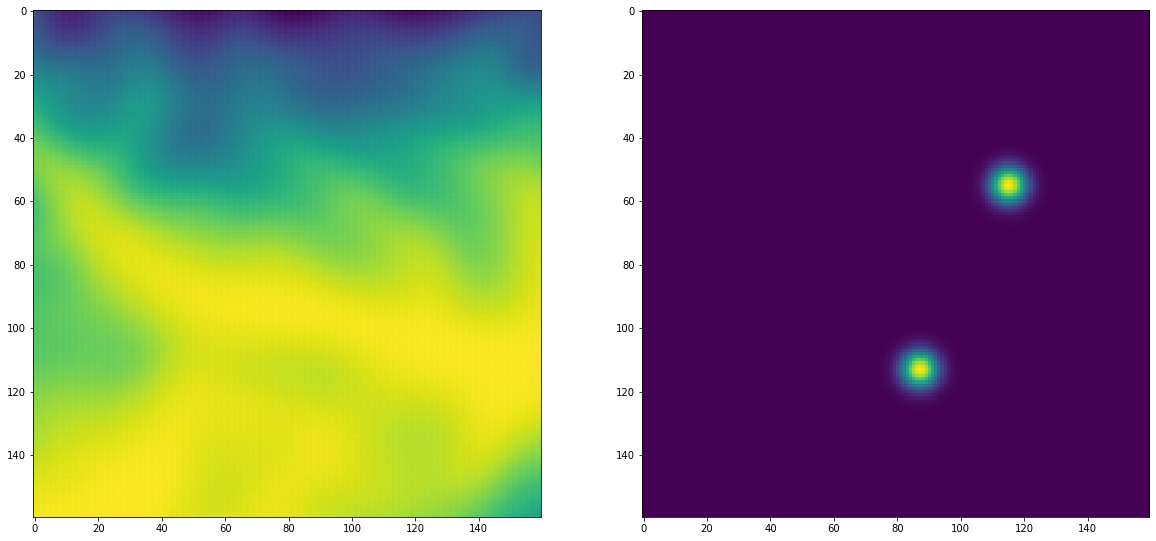

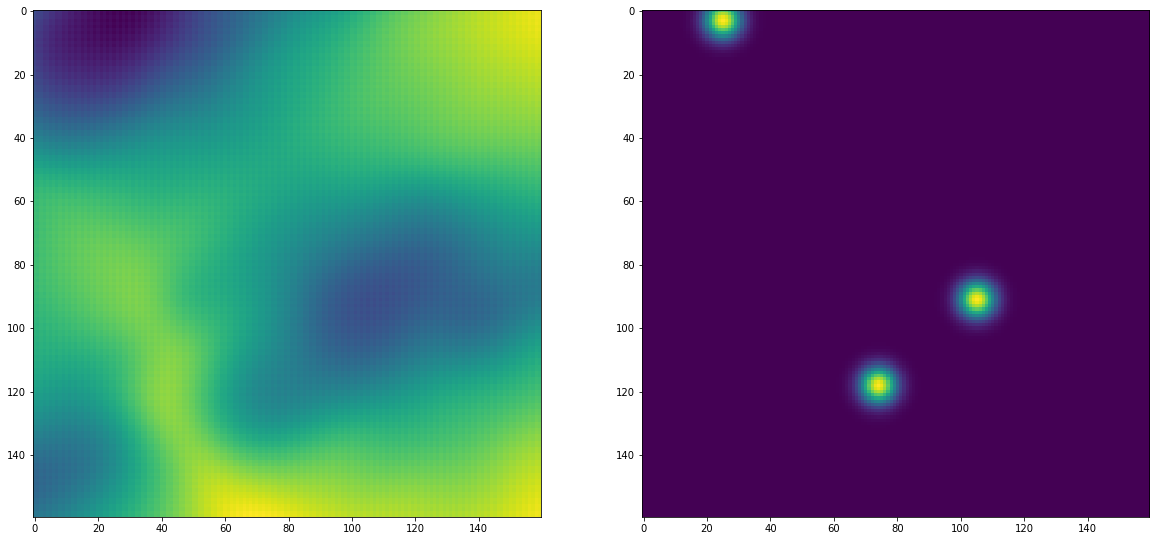


Epoch: 2/60 -- Epoch Time: 156.20 s
---------------------------------
Train -- Loss: 1607360.031, Acc: 0.00%
Val -- Loss: 134895.680, Acc: 0.00%


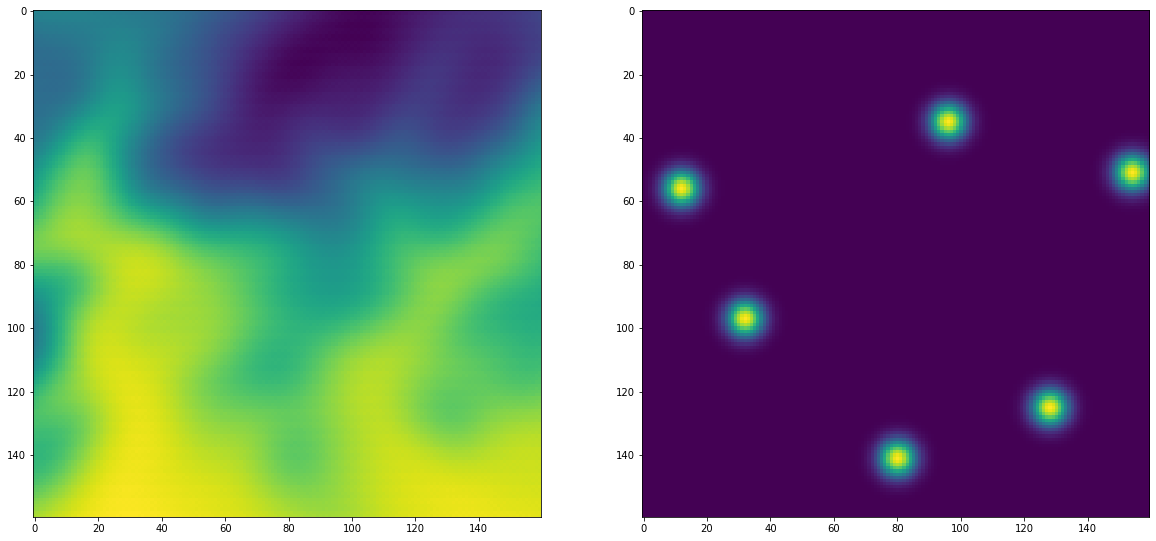

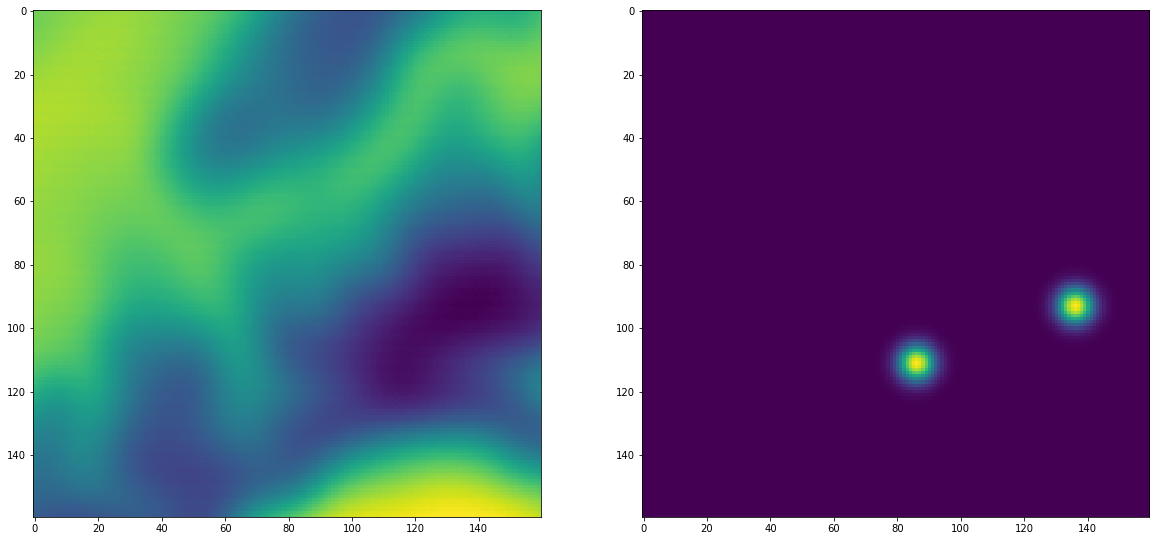

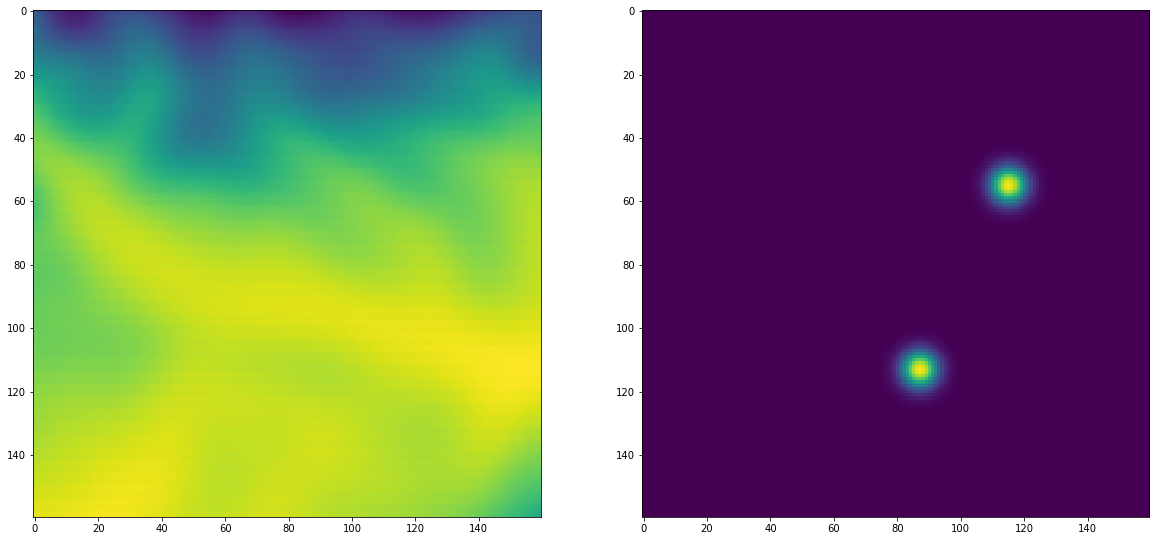

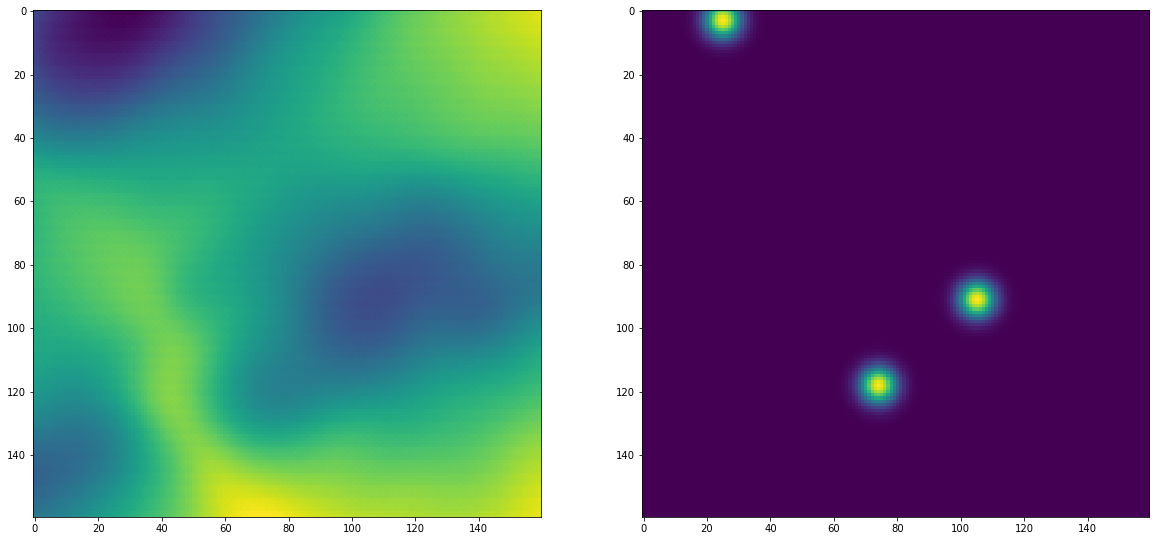


Epoch: 3/60 -- Epoch Time: 167.87 s
---------------------------------
Train -- Loss: 193709.783, Acc: 0.00%
Val -- Loss: 15176.792, Acc: 0.00%


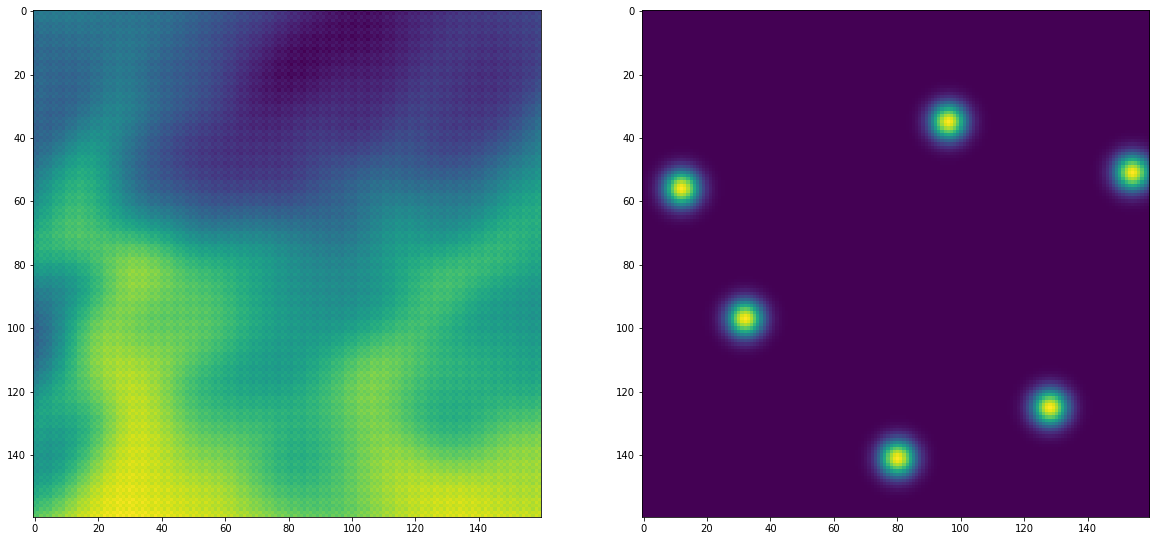

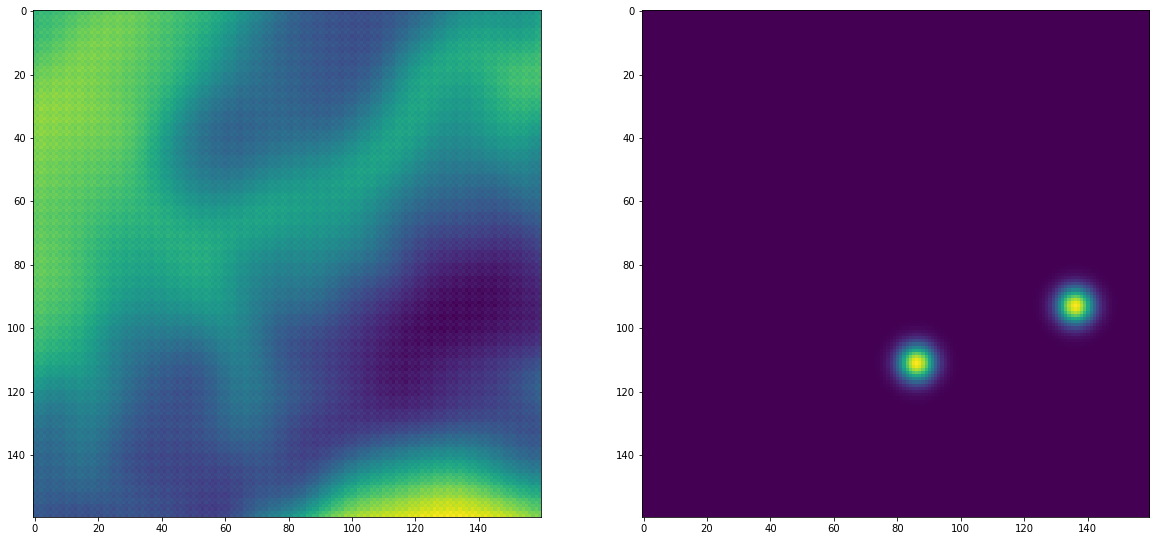

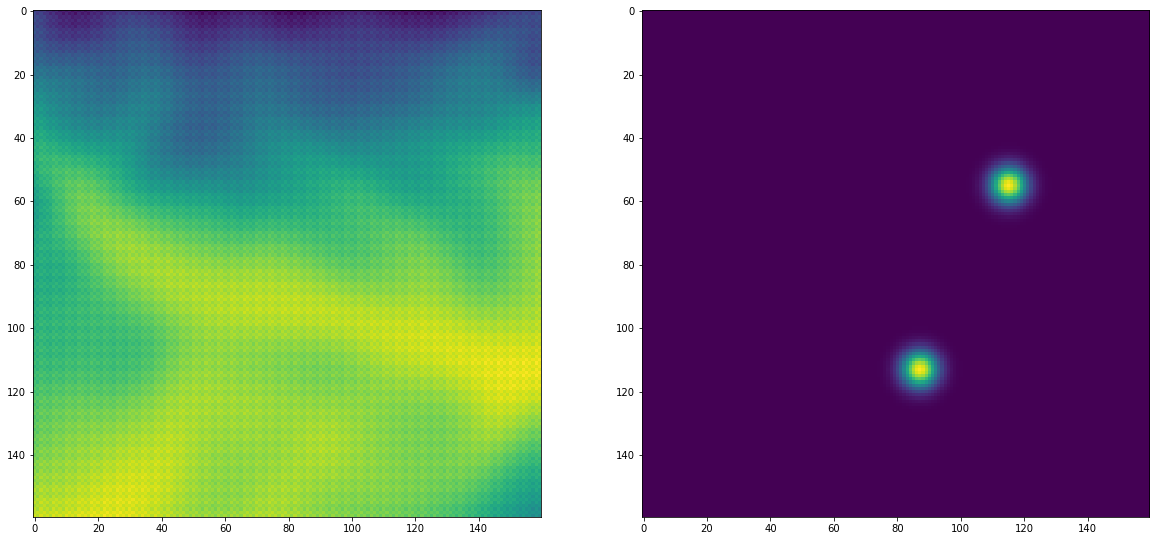

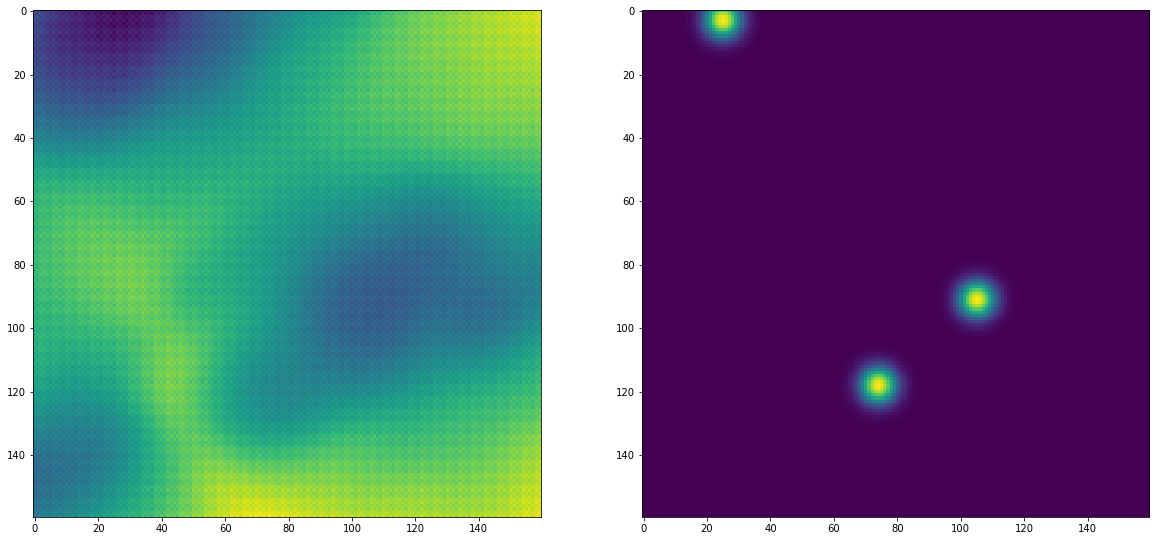


Epoch: 4/60 -- Epoch Time: 162.42 s
---------------------------------
Train -- Loss: 229114.049, Acc: 0.00%
Val -- Loss: 18886.464, Acc: 0.00%


In [ ]:
N_EPOCHS = 60
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, 
                                                                    model, 
                                                                    train_iterator, 
                                                                    valid_iterator, 
                                                                    optimizer, 
                                                                    criterion, 
                                                                    device,
                                                                    'unet.pt')

In [ ]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [ ]:
savePath = "./TODO"
model.save_model(savepath)

In [ ]:
loadPath = savepath
model = torch.load(loadPath)
model.eval()